In [173]:
from importlib import reload
from IPython.core.interactiveshell import InteractiveShell
%load_ext autoreload
InteractiveShell.ast_node_interactivity = "all"
import logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import pandas as pd
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load Data

In [175]:
# experiment specific
result_base_dir = "frame0_1830_expAsRef_ssDDA_P064428_Fresh1_5ug_R1_BD5_1_4921_ScanByScan_RTtol0.0_threshold_missabthres0.5_convergence_NoIntercept_exp_mzBinDigits2_imPeakWidth4_deltaMobilityThres200"

In [176]:
# edit experiment specific data path and config
import json

result_parent_dir = "/cmnfs/proj/ORIGINS/data/brain/FreshFrozenBrain/SingleShot/DDA/"

result_dir = os.path.join(result_parent_dir, result_base_dir)
with open(os.path.join(result_dir, "param.json"), mode="r", encoding="utf-8") as file:
    config = json.load(file)

maxquant_file_exp = config["MQ_exp_path"]
maxquant_file_ref = os.path.join(result_dir, "maxquant_result_ref.pkl")

In [177]:
maxquant_file_exp

'/cmnfs/proj/ORIGINS/data/brain/txt_ssDDA_LFQ_noMBR/evidence_fresh1.txt'

In [163]:
maxquant_result_dict = pd.read_pickle(filepath_or_buffer=maxquant_file_ref)
maxquant_result_exp = pd.read_csv(
    maxquant_file_exp, sep="\t", low_memory=False)
ms1scans = pd.read_csv(os.path.join(result_dir, "ms1scans.csv"), index_col=0)

In [164]:
output_peaks = pd.DataFrame()
for batch_idx in range(config["n_cpu"]):
    peaks_df = pd.read_csv(
        os.path.join(result_dir, "outputbatch_peaks_df_" +
                     str(batch_idx) + ".csv"),
        index_col=0,
    )
    output_peaks = pd.concat([output_peaks, peaks_df], axis=0)

In [165]:
output_peaks.widths.describe()

count    278953.000000
mean         16.871131
std          20.628739
min           4.000000
25%           5.000000
50%           8.000000
75%          21.000000
max         437.000000
Name: widths, dtype: float64

In [167]:
activation = pd.pivot_table(
    output_peaks,
    values="peak_sum",
    index="frame_indices",
    columns=["pept_mzrank"],
    aggfunc="sum",
)

In [168]:
sum_raw = activation.sum(axis=0)
sum_raw = pd.DataFrame(
    sum_raw, columns=["sum_raw"]).reset_index(names="mz_rank")

In [169]:
auc_raw = activation.fillna(0).apply(
    lambda x: np.trapz(x, x=ms1scans.loc[activation.index, "Time"].values), axis=0
)
auc_raw = pd.DataFrame(auc_raw, columns=["auc_raw"]).reset_index(names="mz_rank")

In [58]:
sum_raw["sum_raw_filtered"] = sum_raw["sum_raw"]
sum_raw.loc[sum_raw["sum_raw"] <= 1000, "sum_raw_filtered"] = 0

In [170]:
maxquant_result_dict["predicted_RT"] = maxquant_result_dict["Retention time"]

2024-04-03 16:14:08,032 - result_analysis.result_analysis - INFO - Reference shape: (36743, 81)
2024-04-03 16:14:08,091 - result_analysis.result_analysis - DEBUG - sum cols: ['mz_rank', 'sum_raw']
2024-04-03 16:14:08,227 - result_analysis.compare_maxquant - DEBUG - Maxquant experiment file has 37448 entries.
2024-04-03 16:14:08,228 - result_analysis.compare_maxquant - DEBUG - columns after merge MQ dict and MQ exp Index(['Modified sequence', 'Charge', 'predicted_RT', 'm/z', 'Mass', 'Length',
       'id', 'RT_search_left', 'RT_search_right',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Calibrated retention time', 'Retention time', 'Intensity', '_merge'],
      dtype='object')
2024-04-03 16:14:08,909 - result_analysis.compare_maxquant - INFO - RT overlap counts: full_overlap       37544
partial_overlap     3863
no_overlap          1994
Name: RT_overlap, dtype: int64


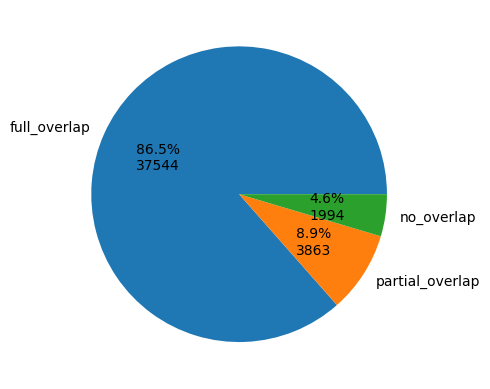

2024-04-03 16:14:09,218 - result_analysis.result_analysis - INFO - No filter_by_rt_overlap is specified, use all entries for plotting.
2024-04-03 16:14:09,265 - result_analysis.compare_maxquant - INFO - Removing 8250 entries with aggregation over PCM, 35151 entries left.
2024-04-03 16:14:09,266 - result_analysis.compare_maxquant - DEBUG - columns after agg Index(['Modified sequence', 'Charge', 'Calibrated retention time start',
       'Calibrated retention time finish', 'Calibrated retention time',
       'Retention time', 'Intensity', 'id', 'Mass', 'm/z', 'Length'],
      dtype='object')
2024-04-03 16:14:09,296 - result_analysis.result_analysis - INFO - Ref exp inner join shape: (36743, 14)


In [171]:
%autoreload 2
from result_analysis.result_analysis import SBSResult
sbs_ims_result = SBSResult(
    maxquant_ref_df=maxquant_result_dict,
    maxquant_exp_df=maxquant_result_exp,
    sum_raw=sum_raw,
    #sum_gaussian = auc_raw,
    ims=True,
)
sbs_ims_result.compare_with_maxquant_exp_int(
    filter_by_rt_overlap=None, save_dir=None)


Data:  Intensity_log sum_raw_log , slope =  0.68 , intercept =  0.672 , PearsonR =  0.696 , SpearmanR =  0.752


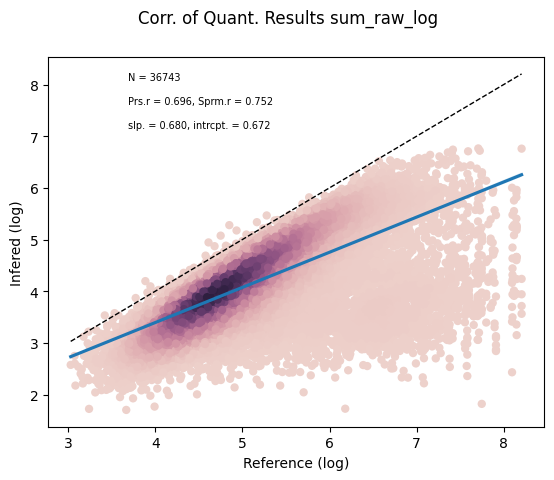

In [172]:
sbs_ims_result.plot_intensity_corr(
    inf_col="sum_raw",
    interactive=False,
    save_dir=None,
    contour=False,
    log_x=True,
    log_y=True,
    hover_data=["mz_rank", "Modified sequence", "Charge"]
    # color=SBS_ss1FDR_PSM.ref_exp_df_inner["Length"],
)

2024-04-03 14:22:07,287 - utils.plot - DEBUG - RT search range: [12.949009017446059, 14.74900901744606]
2024-04-03 14:22:07,288 - utils.plot - DEBUG - mod_seq: _SLYQSAGVAPESFEYIEAHGTGTK_, charge: 3
2024-04-03 14:22:07,293 - utils.plot - DEBUG - RT exp range [array([13.554]), array([13.711])]


,Time_minute,raw,Scan index
0,12.964942,173.522305,NaN
1,12.984647,0.000000,NaN
2,13.004381,11.773809,NaN
3,13.023998,0.000000,NaN
4,13.043576,77.589440,NaN
...,...,...,...
86,14.656036,123.473891,NaN
87,14.675634,0.000000,NaN
88,14.695496,0.000000,NaN
89,14.715132,0.000000,NaN


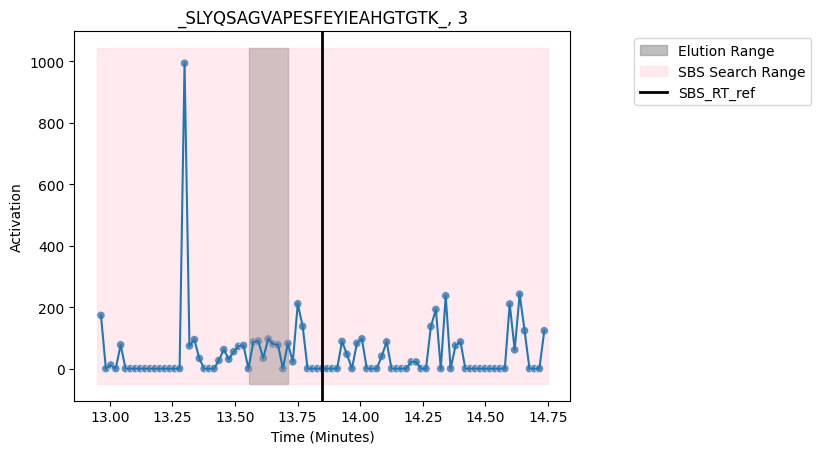

In [135]:
from utils.plot import plot_activation

activation = activation.fillna(0)
pept_idx = 178243
plot_activation(
    maxquant_ref_row=maxquant_result_dict.loc[
        maxquant_result_dict["mz_rank"] == pept_idx, :
    ],
    maxquant_exp_df=maxquant_result_exp,
    precursor_activations=[activation.loc[:, pept_idx]],
    activation_labels=["raw"],
    ms1scan_no_array=ms1scans.loc[activation.index.values],
    ms1scan_time_col="Time_minute",
)

In [5]:
# Make result directory
report_dir = os.path.join(result_dir, "report")
if not os.path.exists(report_dir):
    os.makedirs(report_dir)
    os.makedirs(os.path.join(report_dir, "activation"))

# Statistics

In [7]:
Maxquant_result_dict.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Match time difference',
       'Match m/z difference', 'Match q-value', 'Match score',
       'Number of data points', 'Number of scans', 'Number of isotopic peaks',
       'PIF', 'Fraction of total spectrum', 'Base 

# SBS and MQ Elution(RT) comparison

In [27]:
from result_analysis.result_analysis import FindStartAndEndScan
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

ElutionScan = FindStartAndEndScan(activation=activation)
MS1Scans_NoArray["Scan Index"] = MS1Scans_NoArray.index
MQElutionScan = Maxquant_result_dict[
    [
        "id",
        "Modified sequence",
        "Charge",
        "Retention length",
        "Calibrated retention time start",
        "Calibrated retention time finish",
        "Number of data points",
        "Number of scans",
        "Number of isotopic peaks",
        "Intensity",
        "AUCActivation_Gaussian",
    ]
]
MQElutionScan.sort_values(by="Calibrated retention time start", inplace=True)
MQElutionScan = pd.merge_asof(
    left=MQElutionScan,
    right=MS1Scans_NoArray[["starttime", "Scan Index"]],
    left_on="Calibrated retention time start",
    right_on="starttime",
    direction="nearest",
)
MQElutionScan.sort_values(by="Calibrated retention time finish", inplace=True)
MQElutionScan = pd.merge_asof(
    left=MQElutionScan,
    right=MS1Scans_NoArray[["starttime", "Scan Index"]],
    left_on="Calibrated retention time finish",
    right_on="starttime",
    direction="nearest",
    suffixes=["_start_MQ", "_end_MQ"],
)
MQElutionScan["CountScan_MQ"] = (
    MQElutionScan["Scan Index_end_MQ"] -
    MQElutionScan["Scan Index_start_MQ"] + 1
)
ElutionScan = pd.merge(left=ElutionScan, right=MQElutionScan)
ElutionScan["MQ_SBS_diff"] = ElutionScan["CountScan_MQ"] - \
    ElutionScan["CountScan_SBS"]
ElutionScan["MQ_SBS_start_diff"] = (
    ElutionScan["Scan Index_start_MQ"] - ElutionScan["Scan Index_start_SBS"]
)
ElutionScan["MQ_SBS_end_diff"] = (
    ElutionScan["Scan Index_end_MQ"] - ElutionScan["Scan Index_end_SBS"]
)

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

/tmp/ipykernel_27132/522126409.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MQElutionScan.sort_values(by = 'Calibrated retention time start', inplace=True)


Data:  Intensity_log AUCActivation_Gaussian_log , slope =  0.92 , intercept =  -0.315 , PearsonR =  0.813 , SpearmanR =  0.812


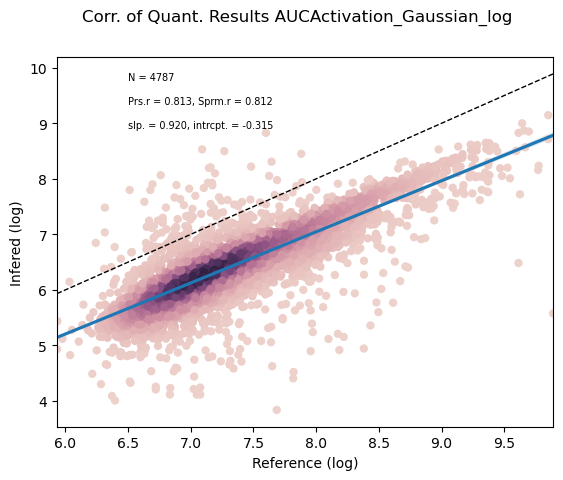

(array([6.09291904, 7.6067549 , 7.27448721, ..., 6.08379386, 7.01468229,
        6.05554934]),
 array([0.09478726, 0.08914836, 0.10194525, ..., 0.14158101, 1.62334872,
        0.29464599]),
 (array([   0,    1,    2, ..., 4945, 4946, 4947]),))

In [29]:
ElutionScan_filtered = ElutionScan[(
    abs(ElutionScan["MQ_SBS_start_diff"]) <= 10)]
PlotCorr(
    ElutionScan_filtered["Intensity"],
    ElutionScan_filtered["AUCActivation_Gaussian"],
    interactive=False,
    data=ElutionScan_filtered,
)

In [20]:
ElutionScan["MQ_SBS_start_diff"].describe()
ElutionScan["MQ_SBS_end_diff"].describe()

count    15131.000000
mean        15.201969
std        158.183104
min      -2032.000000
25%        -18.000000
50%         -1.000000
75%         43.000000
max       2519.000000
Name: MQ_SBS_start_diff, dtype: float64

count    15131.000000
mean         0.041174
std        159.956517
min      -2014.000000
25%        -50.000000
50%          0.000000
75%         12.000000
max       2452.000000
Name: MQ_SBS_end_diff, dtype: float64

count    13564.000000
mean       -17.646859
std         28.656715
min       -154.000000
25%        -41.000000
50%        -13.000000
75%          5.000000
max        241.000000
Name: MQ_SBS_diff, dtype: float64

<Axes: >

Text(0.5, 0, 'Elution Scan Count MQ - Elution Scan Count SBS')

Text(0, 0.5, 'count')

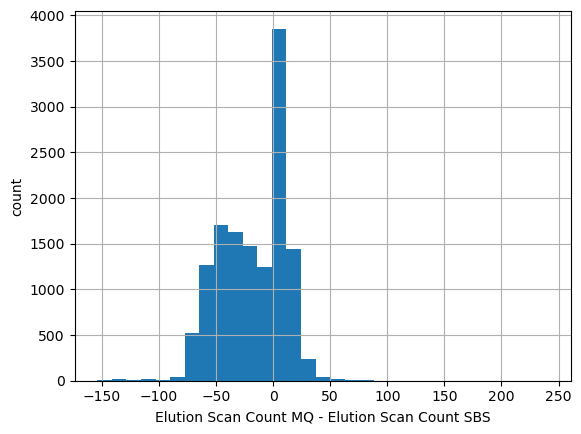

In [10]:
import matplotlib.pyplot as plt

ElutionScan = ElutionScan.dropna(subset=["Intensity"])
ElutionScan["MQ_SBS_diff"].describe()
ElutionScan["MQ_SBS_diff"].hist(bins=31)
plt.xlabel("Elution Scan Count MQ - Elution Scan Count SBS")
plt.ylabel("count")

# Alphas

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

Alpha range:  [1.e-05 1.e-04 1.e-03 0.e+00 1.e-02 1.e-01 1.e+00 1.e+01] , replacing all zeros with 1.0000000000000002e-06


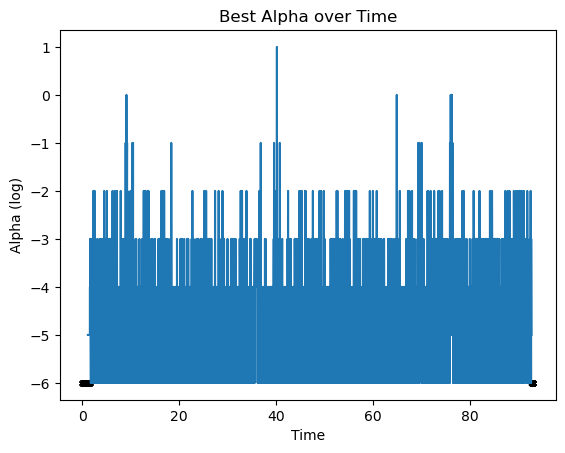

In [65]:
from result_analysis.result_analysis import plot_alphas_across_scan
import result_analysis.result_analysis

reload(result_analysis.result_analysis)

plot_alphas_across_scan(NonEmptyScans=NonEmptyScans,
                        EmptyScans=emptyScans, x="Time")

# Batch Correlation and Report

In [39]:
from result_analysis.result_analysis import PlotCorr
import result_analysis.result_analysis
import utils.plot

reload(utils.plot)

reload(result_analysis.result_analysis)

for sum_col in [
    sum_minima.iloc[:, 0],
    sum_minima.iloc[:, 1],
    sum_minima.iloc[:, 2],
    sum_gaussian.iloc[:, 0],
    sum_gaussian.iloc[:, 1],
    sum_gaussian.iloc[:, 2],
    Maxquant_result_dict["SumActivation"],
]:
    print(sum_col.name)
    _, _, _ = PlotCorr(
        Maxquant_result_dict["Intensity"], sum_col, data=None, save_dir=report_dir
    )

<module 'utils.plot' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utils/plot.py'>

<module 'result_analysis.result_analysis' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/result_analysis/result_analysis.py'>

SumActivationLocalMinima
Data:  Intensity_log SumActivationLocalMinima_log , slope =  0.969 , intercept =  1.033 , PearsonR =  0.901 , SpearmanR =  0.889
AUCAcitvationLocalMinima
Data:  Intensity_log AUCAcitvationLocalMinima_log , slope =  0.961 , intercept =  -0.515 , PearsonR =  0.902 , SpearmanR =  0.889
TRPZActivationLocalMinima
Data:  Intensity_log TRPZActivationLocalMinima_log , slope =  0.961 , intercept =  -0.515 , PearsonR =  0.902 , SpearmanR =  0.889
SumActivationGaussianKernel
Data:  Intensity_log SumActivationGaussianKernel_log , slope =  0.975 , intercept =  0.92 , PearsonR =  0.906 , SpearmanR =  0.895
AUCAcitvationGaussianKernel
Data:  Intensity_log AUCAcitvationGaussianKernel_log , slope =  0.966 , intercept =  -0.627 , PearsonR =  0.908 , SpearmanR =  0.895
TRPZActivationGaussianKernel
Data:  Intensity_log TRPZActivationGaussianKernel_log , slope =  0.966 , intercept =  -0.627 , PearsonR =  0.908 , SpearmanR =  0.895
SumActivation
Data:  Intensity_log SumActivation_lo

In [62]:
from result_analysis.result_analysis import GenerateResultReport
NonEmptyScans = GenerateResultReport(emptyScans= emptyScans, 
                                     NonEmptyScans=NonEmptyScans,
                                     intensity_cols=[Maxquant_result_dict['Intensity'],
                                                    Maxquant_result_dict['SumActivation'], 
                                                    sum_gaussiadf_percentage_change["Change"]n.iloc[:, 0],
                                                    sum_gaussian.iloc[:, 1],
                                                    sum_minima.iloc[:, 0],
                                                    sum_minima.iloc[:, 1]
                                                    ],
                                     save_dir=report_dir)

-------------- Intensity -----------------
Non zero intensity in Intensity = 17477
-------------- SumActivation -----------------
Non zero intensity in SumActivation = 19418
-------------- SumActivationGaussianKernel -----------------
Non zero intensity in SumActivationGaussianKernel = 19418
-------------- AUCAcitvationGaussianKernel -----------------
Non zero intensity in AUCAcitvationGaussianKernel = 19418
-------------- SumActivationLocalMinima -----------------
Non zero intensity in SumActivationLocalMinima = 19418
-------------- AUCAcitvationLocalMinima -----------------
Non zero intensity in AUCAcitvationLocalMinima = 19418
--------------Empty Scans-----------------
Emptry Scans time distribution:
count    724.000000
mean      16.376719
std       34.606065
min        0.002775
25%        0.423449
50%        0.847510
75%        1.382445
max       92.998972
Name: Time, dtype: float64
--------------Non Empty Scans-----------------
Non Emptry Scans reconstruction cosine distance distr

### Plot Activation

In [67]:
from result_analysis.result_analysis import PlotActivation

for idx in Accurate50_idx:
    _ = PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "accurate"),
    )
for idx in Inaccurate50_idx:
    _ = PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "inaccurate"),
    )

### Precursor specific trouble shooting

In [6]:
# Load MS1 scans from pkl or mzml file
msconvert_file = (  # path to the data input in mzML format, containing only MS1 level data
    "/mnt/cmnfs/proj/ORIGINs/protMSD/GCF_profile/msconvert_profile.mzML"
)
with open(msconvert_file[:-5] + ".pkl", "rb") as f:
    MS1Scans = pickle.load(f)

In [27]:
from optimization.dictionary import CalcModpeptIsopattern

Maxquant_result_dict["IsoMZ"], Maxquant_result_dict["IsoAbundance"] = zip(
    *Maxquant_result_dict.apply(
        lambda row: CalcModpeptIsopattern(
            modpept=row["Modified sequence"], charge=row["Charge"], ab_thres=0.001
        ),
        axis=1,
    )
)

<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Precursor  18083 eluted at  76.242 , corresponding scan index  3829 with scan time  76.2416156238556


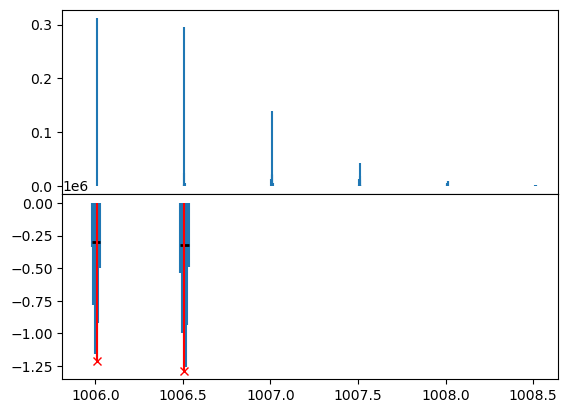

,apex_mzidx,apex_mz,start_mzidx,start_mz,end_mzidx,end_mz,peak_width,peak_height,peak_intensity_sum
0,7,1006.007087,4,1005.978361,9,1006.026239,0.047878,302067.40625,4.906113e+06
1,20,1006.505206,18,1006.486040,23,1006.533955,0.047914,321781.87500,5.505740e+06


In [28]:
from result_analysis.result_analysis import PlotIsoPatternAndScan

PlotIsoPatternAndScan(
    MS1Scans=MS1Scans,
    Maxquant_result=Maxquant_result_dict,
    scan_idx=None,
    precursor_idx=18083,
    log_intensity=False,
)

<module 'utility' from '/mnt/cmnfs/proj/ORIGINS/protMSD/maxquant/ScanByScan/utility.py'>

Cosine distance of non zero entries in prediction: 0.00980649186033511
Intensity Explained: 0.0434
Peaks Explained: 0.4591


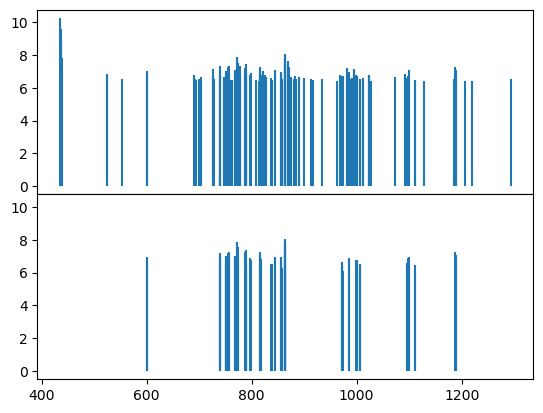

In [29]:
from optimization.dictionary import ConstructDict
from result_analysis.result_analysis import PlotTrueAndPredict

alignment = []
scan_idx = 3830
RT_tol = 1
alpha = 10
# example: generate dictionary for candidate in one scan
OneScan = MS1Scans.iloc[scan_idx, :]
CandidatePrecursorsByRT = Maxquant_result_dict.loc[
    (
        Maxquant_result_dict["Calibrated retention time start"] - RT_tol
        <= OneScan["starttime"]
    )
    & (
        Maxquant_result_dict["Calibrated retention time finish"] + RT_tol
        >= OneScan["starttime"]
    )
]
if CandidatePrecursorsByRT.shape[0] > 0:
    (
        CandidateDict,
        CandidatePrecursorsByRT,
        alignment,
        IsotopeNotObs,
        y_true,
        peak_results,
    ) = ConstructDict(CandidatePrecursorsByRT, OneScan, method="peakRange")
    filteredPrecursorIdx = np.array(CandidateDict.columns[0:], dtype=int)
    if CandidateDict.shape[1] > 1:
        (
            activationByScan,
            lossByScan,
            scoreByScan,
            pred,
            IntensityExplained,
            peaksExplained,
        ) = utility.CalcPrecursorQuant(
            CandidateDict,
            y_true,
            filteredPrecursorIdx=filteredPrecursorIdx,
            alpha=alpha,
        )
        activation[filteredPrecursorIdx, scan_idx] = activationByScan
        # non_empty_scans.append((scan_idx, OneScan['starttime'], lossByScan, scoreByScan, CandidatePrecursorsByRT.index, filteredPrecursorIdx))
        # ScanProcessRecords[scan_idx] = {'alignment':alignment}
        PlotTrueAndPredict(
            x=CandidateDict.index, prediction=pred, true=y_true["intensity"], log=True
        )
        print("Cosine distance of non zero entries in prediction:", scoreByScan)
        print("Intensity Explained:", np.round(IntensityExplained, 4))
        print("Peaks Explained:", np.round(peaksExplained, 4))
    else:
        print(
            "Scan number, start time ",
            scan_idx,
            OneScan["starttime"],
            "does not have valid candidate.",
        )
        # empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate after isotope pattern matching.'))

else:
    print(
        "Scan number, start time ",
        scan_idx,
        OneScan["starttime"],
        "does not have valid candidate.",
    )
    # empty_scans.append((scan_idx, OneScan['starttime'], 'No valid candidate by RT'))

In [30]:
alignment[303]["abundance"].sum()
IsotopeNotObs[303]["abundance"].sum()

0.5232761444636144

0.4490588887347563

In [32]:
Maxquant_result_dict.loc[11557, "IsoAbundance"].sum()

0.9723350331983707

In [33]:
idx = np.where(filteredPrecursorIdx == 18082)
activationByScan[idx]

array([9769022.28253018])

In [17]:
import IsoSpecPy as iso

pair = [18083, 18082]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
18083,_VNQIGTLTETFEAIEM(ox)AK_,2,76.242,27290000.0,1006.00626
18082,_VNQIGTLTETFEAIEM(ox)AK_,2,75.905,NaN,1006.00626


OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

OrderedDict([('C', 99), ('H', 162), ('N', 24), ('O', 32), ('S', 1)])

In [122]:
import IsoSpecPy as iso

Maxquant_result_dict.loc[
    [738, 10695], ["Modified sequence", "Charge",
                   "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[738, "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[10695, "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
738,_AISVDELQK_,2,21.921,26158000.0,501.776939
10695,_LGLENVETK_,2,21.921,26158000.0,501.776939


OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

OrderedDict([('C', 43), ('H', 73), ('N', 11), ('O', 15), ('S', 0)])

In [121]:
pair = [15879, 12747]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
15879,_TDLINAVAEASSLSK_,2,70.373,20798000.0,759.904128
12747,_NIFSDPLTIEEIK_,2,70.373,20798000.0,759.906139


OrderedDict([('C', 64), ('H', 109), ('N', 17), ('O', 24), ('S', 0)])

OrderedDict([('C', 69), ('H', 109), ('N', 15), ('O', 22), ('S', 0)])

In [127]:
pair = [3772, 3774]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
3772,_EHGAVFIIGIGDALR_,3,62.458,7362600.0,523.291219
3774,_EHGAVFIIGIGDALR_,3,62.330,NaN,523.291219


OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

OrderedDict([('C', 71), ('H', 112), ('N', 20), ('O', 19), ('S', 0)])

In [128]:
pair = [15120, 14965]
Maxquant_result_dict.loc[
    pair, ["Modified sequence", "Charge", "Retention time", "Intensity", "m/z"]
]
iso.ParseFASTA(Maxquant_result_dict.loc[pair[0], "Modified sequence"])
iso.ParseFASTA(Maxquant_result_dict.loc[pair[1], "Modified sequence"])

,Modified sequence,Charge,Retention time,Intensity,m/z
15120,_SLAEQNVILCFASGR_,2,62.377,8509700.0,832.924871
14965,_SIAAFAIHQFFQER_,2,62.060,NaN,832.930814


OrderedDict([('C', 69), ('H', 112), ('N', 20), ('O', 21), ('S', 1)])

OrderedDict([('C', 78), ('H', 111), ('N', 21), ('O', 19), ('S', 0)])

In [129]:
for idx in [738, 10695] + [15120, 14965] + [3772, 3774] + [15879, 12747]:
    _ = postprocessing.post_processing.PlotActivation(
        MaxquantEntry=Maxquant_result_dict.iloc[idx, :],
        PrecursorTimeProfiles=[
            activation[idx, :],
            refit_activation_minima[idx, :],
            refit_activation_gaussian[idx, :],
        ],
        PrecursorTimeProfileLabels=["None", "LocalMinima", "Gaussian"],
        MS1ScansNoArrary=MS1Scans_NoArray,
        save_dir=os.path.join(report_dir, "activation", "outliers"),
    )